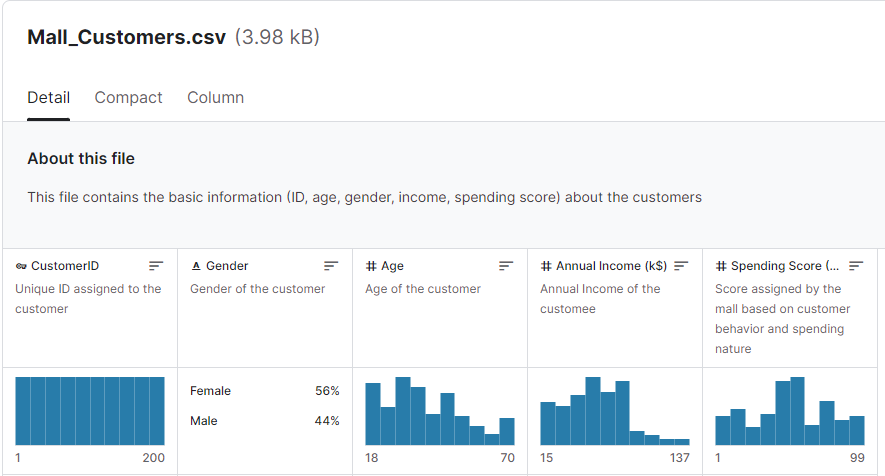

# Library Imports and Setup

In [1]:
# Install the mxnet library required for certain functionalities in SageMaker
!pip install mxnet

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import boto3
from botocore.exceptions import ClientError

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Libraries
import tarfile
import mxnet as mx
import datetime
import json
import time
from tabulate import tabulate
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# SageMaker Setup and Configuration

In [2]:
# Initialize a SageMaker Session
# A SageMaker Session helps in managing the interactions with the AWS SageMaker service, such as creating and training models, and deploying endpoints.
sagemaker_session = sagemaker.Session()

# Retrieve the IAM role
# The IAM role is required by SageMaker to access AWS resources (e.g., S3 buckets) on your behalf.
role = get_execution_role()

# Identify the AWS Region of the SageMaker Session
# This information is used to ensure that resources are created in the same region as the SageMaker session.
region = sagemaker_session.boto_region_name

# Create Boto3 Clients for S3 and SageMaker
# These clients enable programmatic access to S3 and SageMaker services for operations like uploading data and creating training jobs.
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

# Retrieve the Docker image URI for the KMeans algorithm
# This URI is specific to the AWS region and is used to pull the appropriate image for training.
image_uri = retrieve('kmeans', region)

# Define the Default S3 Bucket for SageMaker
# SageMaker requires an S3 bucket to store training data, models, and outputs. Here, we use the session's default bucket.
bucket = sagemaker_session.default_bucket()

# Set the S3 Prefix for Storing Data
# The prefix is used to organize the data in the bucket, making it easier to manage and locate.
prefix = 'sagemaker/mall/kmeans-all'

# Output the IAM Role ARN and AWS Region for verification
print("Execution Role ARN:", role)
print("AWS Region:", region)

Execution Role ARN: arn:aws:iam::381492163284:role/LabRole
AWS Region: us-east-1


# Load and Preprocess the Dataset

In [3]:
# Step 1: Load the Dataset
# Load the mall customers dataset from a CSV file into a Pandas DataFrame.
# This allows for easy data manipulation and analysis.
df_mall = pd.read_csv('Mall_Customers.csv')

# Step 2: Select Relevant Features
# Focus on the features 'Age', and 'Spending Score (1-100)' for analysis.
df_mall = df_mall[['Age', 'Spending Score (1-100)']]

# Step 3: Convert Data for Machine Learning
# Convert the selected DataFrame into a NumPy array of type 'float32'.
# This conversion is necessary as most machine learning frameworks work efficiently with NumPy arrays.
data_np = df_mall.values.astype('float32')

# Step 4: Save Preprocessed Data
# Save the preprocessed dataset to a CSV file, without the index.
df_mall.to_csv('mall_data-one-c.csv', index=False)

# Confirming the data has been preprocessed and saved.
print("Preprocessed dataset saved as 'mall_data-one-c.csv'.")

# Display the first few rows of the processed dataset to verify the preprocessing steps.
print(df_mall.head())

Preprocessed dataset saved as 'mall_data-one-c.csv'.
   Age  Spending Score (1-100)
0   19                      39
1   21                      81
2   20                       6
3   23                      77
4   31                      40


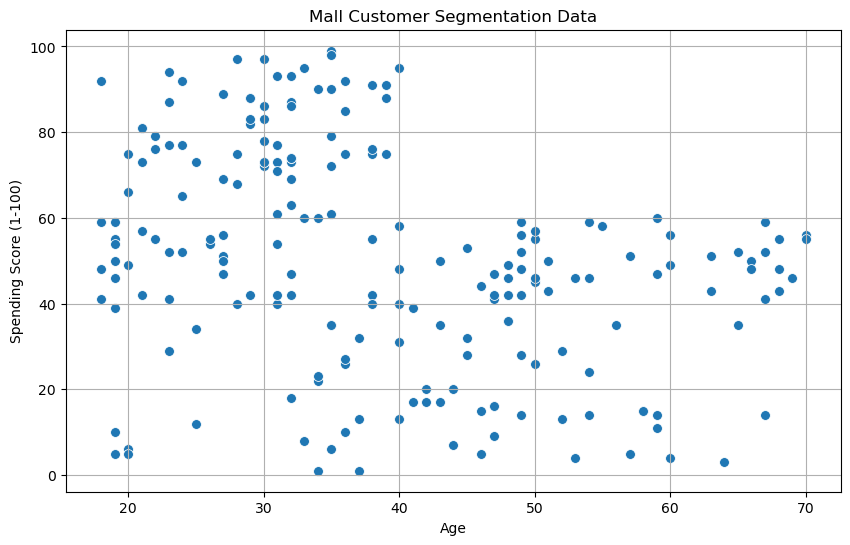

In [4]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create scatter plot using Seaborn
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df_mall, s=50)

# Setting the title and labels of the plot
plt.title('Mall Customer Segmentation Data')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')

# Enabling grid for better readability
plt.grid(True)

# Display the plot
plt.show()

# KMeans Model Training

In [5]:
# Define the range of k values for the KMeans clustering
# This range will determine how many models we train, each with a different number of clusters.
k_values = range(2, 8)

# Initialize lists to keep track of the S3 paths for the trained models and their training job names.
model_paths = []
training_jobs = []

# Set the output path in the S3 bucket for the trained models
# This path will be used to store the output (model artifacts) of each training job.
output_path = f's3://{sagemaker_session.default_bucket()}/sagemaker/mall/kmeans-one-c/output'

# Iterate over each k value to train a separate KMeans model for that number of clusters
for k in k_values:
    # Generate a unique job name for each training job based on the k value
    job_name = f'kmeans-mall-one-c-k-{k}'
    
    # Initialize the KMeans estimator from SageMaker with the specific k value
    # Configuration includes instance type, number of instances, and the specified k value.
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.large',
        k=k,
        output_path=output_path,
        job_name=job_name,
        feature_dim=2  # Specify the number of features in the input data
    )
    
    # Start the training job for the KMeans model
    # We use 'wait=False' to start each training job asynchronously.
    kmeans.fit(kmeans.record_set(data_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# After initiating all training jobs, we wait for each to complete and collect their model URIs
for k, job_name in training_jobs:
    # Wait for the completion of the training job
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    
    # Retrieve the S3 URI of the model artifacts for the completed training job
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts']
    model_paths.append((k, model_s3_uri))

# Print the S3 paths of the model artifacts for all trained models
# This provides a clear reference to the location of each model for further analysis or deployment.
headers = ['k Value', 'S3 Model Artifact Path']
print(tabulate(model_paths, headers=headers))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-17-20-55-02-930
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-17-20-55-03-420
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris

  k Value  S3 Model Artifact Path
---------  ---------------------------------------------------------------------------------------------------------------------------
        2  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-c/output/kmeans-2024-03-17-20-55-02-930/output/model.tar.gz
        3  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-c/output/kmeans-2024-03-17-20-55-03-420/output/model.tar.gz
        4  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-c/output/kmeans-2024-03-17-20-55-05-521/output/model.tar.gz
        5  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-c/output/kmeans-2024-03-17-20-55-06-316/output/model.tar.gz
        6  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-c/output/kmeans-2024-03-17-20-55-07-780/output/model.tar.gz
        7  s3://sagemaker-us-east-1-381492163284/sagemaker/mall/kmeans-one-c/output/kmeans-2024-03-17-20-55-08-520/output/model.tar.gz


# Model Evaluation

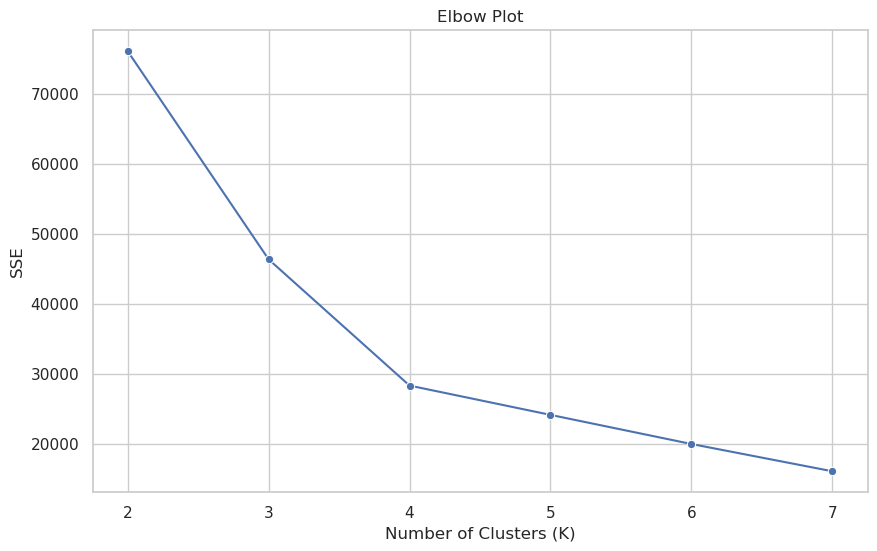

In [6]:
# Extract SSE values from the trained models
sse_values = []  # List to store SSE values for each model

for k, model_path in model_paths:  # Iterate over each model path
    try:
        # Define the local path to save the model
        local_path = f'/tmp/model-k-{k}.tar.gz'
        # Download the model from S3 to the local path
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model files from the tar archive
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        # Extract the centroids from the model parameters
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate the distances between each data point and the centroids
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        # Calculate the SSE for the current model
        sse = np.sum((data_np - centroids[closest_centroids])**2)
        
        # Append the SSE value to the list
        sse_values.append(sse)
    except Exception as e:  # Catch any exceptions during the process
        print(f'Error processing model for K={k}: {e}')  # Print the error message

# Plot the Elbow Plot
sns.set_theme(style="whitegrid")  # Set the Seaborn theme for the plots

plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')  # Plot the Elbow Plot using Seaborn
plt.title('Elbow Plot')  # Set the plot title
plt.xlabel('Number of Clusters (K)')  # Set the x-axis label
plt.ylabel('SSE')  # Set the y-axis label
plt.xticks([k for k, _ in model_paths])  # Set the x-axis ticks
plt.show()  # Display the plot


In [7]:
# Specify the best K value
best_k = 4

# Find the model path for the best K value
best_model_path = next(path for k, path in model_paths if k == best_k)

# Define the local path to save the best model
local_path = '/tmp/best_model.tar.gz'

# Download the best model from S3 to the local path
s3_client.download_file(sagemaker_session.default_bucket(), best_model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)

# Extract the model parameters
with tarfile.open(local_path) as tar:
    tar.extractall(path='/tmp/best_model')

# Load the best KMeans model parameters
kmeans_best_params = mx.ndarray.load('/tmp/best_model/model_algo-1')
centroids_best = kmeans_best_params[0].asnumpy()  # Extract the centroids

# Calculate the closest centroids for each data point
distances_best = np.sqrt(((data_np - centroids_best[:, np.newaxis])**2).sum(axis=2))
cluster_labels = np.argmin(distances_best, axis=0)  # Assign clusters

# Add cluster labels to the DataFrame
df_mall['Cluster'] = cluster_labels

# Calculate and print the model metrics
sse_best = np.sum((data_np - centroids_best[cluster_labels])**2)
print(f"Model Metrics for Best K ({best_k}):")
print(f"SSE: {sse_best}")


Model Metrics for Best K (4):
SSE: 28333.171875


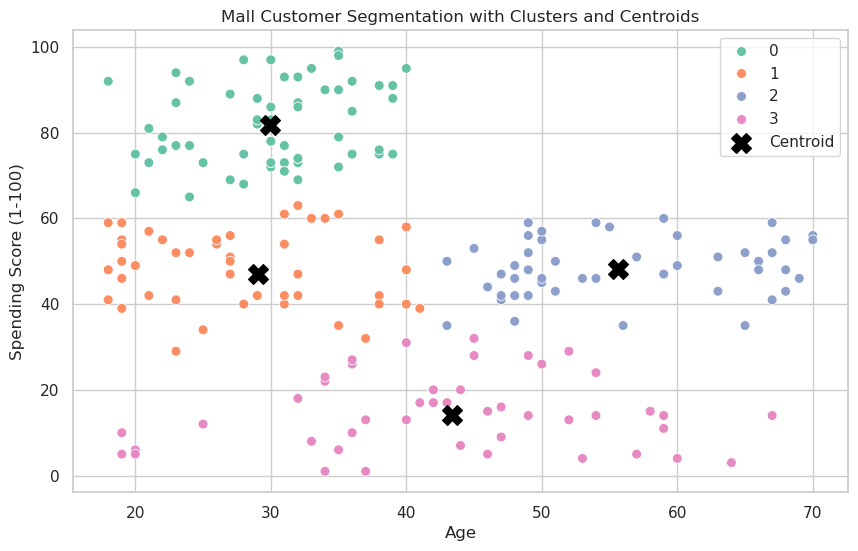

In [9]:
# Set the Seaborn theme for the plots
sns.set_theme(style="whitegrid")

# Plot the data points with cluster assignments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mall, x='Age', y='Spending Score (1-100)', hue='Cluster', palette='Set2', s=50)

# Plot the centroids
for i, centroid in enumerate(centroids_best):
    plt.scatter(centroid[0], centroid[1], s=200, c='black', marker='X', label=f'Centroid' if i == 0 else None)

plt.title('Mall Customer Segmentation with Clusters and Centroids')  # Set the plot title
plt.xlabel('Age')  # Set the x-axis label
plt.ylabel('Spending Score (1-100)')  # Set the y-axis label
plt.legend()  # Show the legend
plt.show()  # Display the plot

# Model Deployment to SageMaker Endpoint

In [10]:
# Specify names for the endpoint and its configuration
endpoint_name = 'mall-kmeans-one-c'
endpoint_config_name = 'mall-kmeans-one-c'

# Function to wait for endpoint configuration deletion
def wait_for_endpoint_config_deletion(endpoint_config_name):
    print(f'Waiting for endpoint configuration "{endpoint_config_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint configuration if it exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    wait_for_endpoint_config_deletion(endpoint_config_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')

# Function to wait for endpoint deletion
def wait_for_endpoint_deletion(endpoint_name):
    print(f'Waiting for endpoint "{endpoint_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint if it exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    wait_for_endpoint_deletion(endpoint_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')

# Identify the best model based on prior analysis
best_k = 6  # Assuming best_k is determined through prior analysis
best_model_s3_uri = next(path for k, path in model_paths if k == best_k)

# Create a SageMaker Model object with the best model's artifacts
best_model = Model(
    model_data=best_model_s3_uri,
    image_uri=image_uri,
    role=role,
    sagemaker_session=sagemaker_session
)

# Deploy the model to an endpoint
# Note: This operation can take several minutes to complete.
predictor = best_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

print(f'Model deployed to endpoint: {endpoint_name}')

Endpoint configuration "mall-kmeans-one-c" already exists. Deleting...
Waiting for endpoint configuration "mall-kmeans-one-c" to be deleted...
Endpoint configuration "mall-kmeans-one-c" deleted.
Endpoint "mall-kmeans-one-c" already exists. Deleting...
Waiting for endpoint "mall-kmeans-one-c" to be deleted...


INFO:sagemaker:Creating model with name: kmeans-2024-03-17-21-08-51-311


Endpoint "mall-kmeans-one-c" deleted.


INFO:sagemaker:Creating endpoint-config with name mall-kmeans-one-c
INFO:sagemaker:Creating endpoint with name mall-kmeans-one-c


-------!Model deployed to endpoint: mall-kmeans-one-c


# Cluster Associations and Centroids

In [13]:
# Initialize a Predictor object for the deployed SageMaker endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

def get_user_input(prompt):
    """Function to get user input; allows quitting by typing 'quit'."""
    user_input = input(prompt).strip()
    if user_input.lower() == 'quit':
        return None
    return user_input

def validate_and_prompt(feature_name, feature_prompt):
    """Validate and repeatedly prompt until a valid input or 'quit' is entered."""
    while True:
        user_input = get_user_input(feature_prompt)
        if user_input is None:  # User chose to exit
            return None
        try:
            # Ensure input is within the valid range for Annual Income and Spending Score
            value = float(user_input)
            if feature_name == 'Age' and (0 < value <= 100):
                return str(value)
            elif feature_name == 'Spending Score' and (1 <= value <= 100):
                return str(value)
            else:
                print(f"Please enter a valid {feature_name}.")
        except ValueError:
            print(f"Invalid input. Please enter a number for {feature_name}.")

print("Cluster Prediction Program")
print("Enter your Age and Spending Score for a prediction, or type 'quit' to exit.")

while True:
    # Collect inputs from the user
    age = validate_and_prompt('Age', "Enter Age or type 'quit' to exit: ")
    if age is None: break
    spending_score = validate_and_prompt('Spending Score', "Enter Spending Score (1-100) or type 'quit' to exit: ")
    if spending_score is None: break
    
    # Prepare the data for prediction
    data = f'{age},{spending_score}\n'

    # Make prediction and handle potential errors
    try:
        response = predictor.predict(data)
        # Parse the prediction response
        response_json = json.loads(response)
        cluster = response_json['predictions'][0]['closest_cluster']
        distance = response_json['predictions'][0]['distance_to_cluster']
        # Print the cluster assignment
        print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")
    except Exception as e:
        print(f"An error occurred during prediction: {str(e)}")

print("Program exited.")

Cluster Prediction Program
Enter your Age and Spending Score for a prediction, or type 'quit' to exit.


Enter Age or type 'quit' to exit:  20
Enter Spending Score (1-100) or type 'quit' to exit:  35


The data point belongs to Cluster 4 with a distance of 13.85 to the cluster center.


Enter Age or type 'quit' to exit:  quit


Program exited.


# Delete the Endpoint and Endpoint Config

In [14]:
# Prompt for confirmation before deleting the endpoint and endpoint configuration
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':
    # Create a SageMaker client
    sagemaker_client = boto3.client('sagemaker')

    # Check if the endpoint configuration already exists
    try:
        sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
        else:
            raise

    # Check if the endpoint already exists
    try:
        sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint "{endpoint_name}" does not exist.')
        else:
            raise
else:
    print("Deletion cancelled.")


Are you sure you want to delete the endpoint and endpoint configuration? (yes/no):  yes


Endpoint configuration "mall-kmeans-one-c" already exists. Deleting...
Endpoint configuration "mall-kmeans-one-c" deleted.
Endpoint "mall-kmeans-one-c" already exists. Deleting...
Endpoint "mall-kmeans-one-c" deleted.
